#https://www.pycaret.org/tutorials/html/REG101.html

In [91]:
import pycaret as pyc
import pandas as pd
import numpy as np
import scipy
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
from pycaret.datasets import get_data
from sklearn.linear_model import Lasso
import pyglmnet
import pyogrio
from sklearn.metrics import mean_squared_error

In [4]:
cd "C:/Users/Chad/Desktop/CRWA Project/Working_Data"

C:\Users\Chad\Desktop\CRWA Project\Working_Data


# Cleaning Data

In [ ]:
combined=pd.read_csv('B22023.csv')
for band in ['B3','B4','B5','B6','B7','B8','B8A','B11','B12']:
    current=pd.read_csv(band+'2023.csv')[[band]]
    combined=pd.concat([combined, current], axis=1)

In [ ]:
dates_list=['2023-01-09','2023-01-17','2023-01-27','2023-02-01','2023-02-03','2023-02-08','2023-02-11','2023-02-18',
            '2023-03-05','2023-03-10','2023-03-18','2023-03-20','2023-03-30','2023-04-02','2023-04-04','2023-04-09',
            '2023-04-12','2023-04-14','2023-04-24','2023-05-07','2023-05-09','2023-05-12','2023-05-14','2023-05-17',
            '2023-05-19','2023-05-22','2023-05-24','2023-05-27','2023-05-29','2023-06-06','2023-06-11','2023-06-13',
            '2023-06-16','2023-06-21','2023-06-23','2023-07-06','2023-07-08','2023-07-11','2023-07-13','2023-07-18',
            '2023-07-23','2023-07-26','2023-07-28','2023-08-02','2023-08-05','2023-08-12','2023-08-20','2023-08-22',
            '2023-09-01','2023-09-04','2023-09-06','2023-09-09','2023-09-14','2023-09-19','2023-09-21','2023-09-26',
            '2023-10-01','2023-10-04','2023-10-09','2023-10-11','2023-10-14','2023-10-19','2023-10-24','2023-10-26',
            '2023-10-31','2023-11-03','2023-11-05','2023-11-08','2023-11-13','2023-11-15','2023-11-20','2023-11-23',
            '2023-11-25','2023-11-28','2023-11-30','2023-12-08','2023-12-13','2023-12-20','2023-12-23','2023-12-25']
dates=pd.DataFrame(['2023-01-09','2023-01-17','2023-01-27','2023-02-01','2023-02-03','2023-02-08','2023-02-11','2023-02-18',
            '2023-03-05','2023-03-10','2023-03-18','2023-03-20','2023-03-30','2023-04-02','2023-04-04','2023-04-09',
            '2023-04-12','2023-04-14','2023-04-24','2023-05-07','2023-05-09','2023-05-12','2023-05-14','2023-05-17',
            '2023-05-19','2023-05-22','2023-05-24','2023-05-27','2023-05-29','2023-06-06','2023-06-11','2023-06-13',
            '2023-06-16','2023-06-21','2023-06-23','2023-07-06','2023-07-08','2023-07-11','2023-07-13','2023-07-18',
            '2023-07-23','2023-07-26','2023-07-28','2023-08-02','2023-08-05','2023-08-12','2023-08-20','2023-08-22',
            '2023-09-01','2023-09-04','2023-09-06','2023-09-09','2023-09-14','2023-09-19','2023-09-21','2023-09-26',
            '2023-10-01','2023-10-04','2023-10-09','2023-10-11','2023-10-14','2023-10-19','2023-10-24','2023-10-26',
            '2023-10-31','2023-11-03','2023-11-05','2023-11-08','2023-11-13','2023-11-15','2023-11-20','2023-11-23',
            '2023-11-25','2023-11-28','2023-11-30','2023-12-08','2023-12-13','2023-12-20','2023-12-23','2023-12-25'])
dates['id']=dates.index
combined_wDates=combined.merge(dates,on='id')

In [ ]:
combined_wDates['time']=combined_wDates[0]
gdf = gpd.GeoDataFrame(
    combined_wDates, geometry=gpd.points_from_xy(combined_wDates.longitude, combined_wDates.latitude), crs="EPSG:4326"
)

In [ ]:
gdf['DOY']=0
for i in dates_list:
    DOY=(datetime.fromisoformat(str(i))-datetime.fromisoformat('2023-01-01')).days
    gdf['DOY'][gdf['time']==i]=DOY

In [ ]:
for band in ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']:
    sns.scatterplot(data=gdf,x='DOY',y=band)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# Adds unique identifier for each point, and sorts values by the 80 dates for each point
mygdf=gdf[['time','DOY','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','geometry']]
j=0
mygdf['PtID']=0
mygdf['PtID'] = mygdf.groupby(['geometry']).ngroup()
mygdf=mygdf.sort_values(['PtID','time']).dropna()

In [ ]:
mygdf['NDVI']=(mygdf['B8']-mygdf['B4'])/(mygdf['B8']+mygdf['B4'])
mygdf['NBR'] = (mygdf['B12']-mygdf['B8'])/(mygdf['B12']+mygdf['B8'])
mygdf['SAVI'] = (1.5 * (mygdf['B8'] - mygdf['B4']) / (mygdf['B8'] + mygdf['B4'] + 0.5))
mygdf['RENDVI'] = (mygdf['B6']-mygdf['B5'])/(mygdf['B6']+mygdf['B5'])
mygdf['EVI'] = 2.5 * ((mygdf['B8'] - mygdf['B4']) / (mygdf['B8'] + 6 * mygdf['B4'] - 7.5 * mygdf['B2'] + 1))

In [ ]:
mygdf

In [ ]:
mygdf.to_file('2023BandsIndicesCleaned.shp')

# Can just start from cleaned shapefile

In [5]:
mygdf=gpd.read_file('2023BandsIndicesCleaned.shp',engine="pyogrio")

<Axes: xlabel='DOY', ylabel='NDVI'>

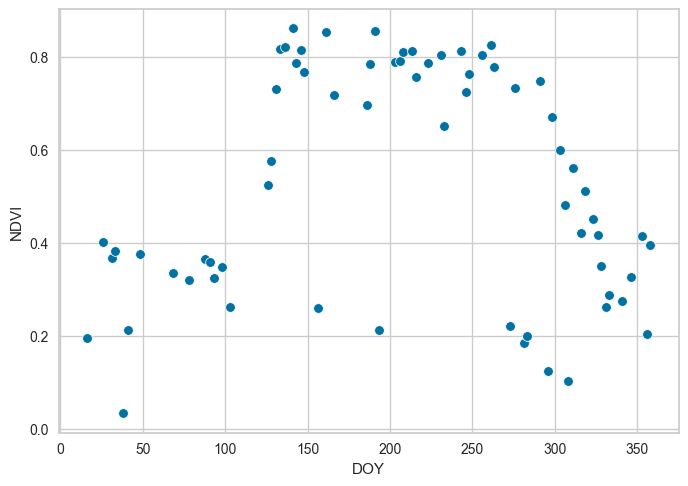

In [30]:
sns.scatterplot(mygdf[mygdf['PtID']==1],x='DOY',y='NDVI')

In [100]:
def harmonicfunc(mult,one,two,x):
    w=2*np.pi/365.25
    return one*np.cos(mult*w*x)+two*np.sin(mult*w*x)

In [101]:
def myobj(x,a,b,c,d,e,f,g,h,i):  
    return a+harmonicfunc(1,b,c,x)+harmonicfunc(2,d,e,x)+harmonicfunc(3,f,g,x)+harmonicfunc(4,h,i,x)

In [106]:
def curvefit(PtID,band):
    x=mygdf[mygdf['PtID']==PtID]['DOY']
    y=mygdf[mygdf['PtID']==PtID][band]
    popt,pcov=scipy.optimize.curve_fit(myobj, x,y)
    yhat=myobj(x,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8])
    RMSE=np.sqrt(mean_squared_error(y, yhat))
    return RMSE,popt

In [124]:
for band in ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','NDVI','NBR','SAVI','RENDVI','EVI']:
    output_df=mygdf[['PtID']]
    RMSE_res=np.zeros((output_df.size,1))
    popt_res=np.zeros((output_df.size,9))
    for i in mygdf['PtID']:
        RMSE_res[i,:],popt_res[i,:]=curvefit(i,band)
    output_df['RMSE']=RMSE_res
    output_df[band+'a']=popt_res[:,0]

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


KeyboardInterrupt: 

# How do I get this into pycaret?

In [ ]:
# Need to split number of points randomly into train and test?
# P is total number of points, M is number of points for train dataset, N is number of points for test dataset
rng = np.random.default_rng(seed=121)
frac_test=0.3
P=mygdf[['PtID']].drop_duplicates().size
M=int(P*(1-frac_test))
N=int(P*frac_test)

In [ ]:
# Randomly select the PtIDs for the needed number of examples from the set for train
train_indices=rng.choice(np.arange(0,P), size = M, replace = False, p = None)
# The test indices are the other rows that were not selected
test_indices=np.arange(0,P)[~np.isin(np.arange(0,P),train_indices)]

In [ ]:
train_indices

In [ ]:
#Random splitting of points into test and train
train_df=mygdf[mygdf['PtID'].isin(train_indices)]
test_df=mygdf[mygdf['PtID'].isin(test_indices)]

In [ ]:
sns.scatterplot(data=test_df[test_df['PtID']==5],x='DOY',y='')

In [ ]:
train=train_df[['DOY','B6']]
test=test_df[['DOY','B6']]
alldata=mygdf[['DOY','B6']]

# Scratch Workspace

In [ ]:
comparemodels

In [ ]:
sns.scatterplot(data=train,x='DOY',y='B6')
sns.scatterplot(data=test,x='DOY',y='B6')

In [ ]:
plt.plot(X,best.predict(X))

In [ ]:
s=setup(data=train,test_data=test,target='NDVI',session_id = 123,index=False)

In [ ]:
best = compare_models()

In [ ]:
plot_model(best, plot = 'error')